# Renderings

Notebook for creating renderings for the presentation

### 0 Imports

In [1]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import matplotlib.cm as cm
import ipywidgets as widgets
from ipyevents import Event
import time
import gymnasium as gym
import torch
import torch.nn as nn
from typing import Any, cast
from collections import deque
import random
import cv2
from IPython.display import HTML
from matplotlib.patches import FancyArrow
import pickle

In [2]:
sys.path.insert(1, str(Path("..")))
from andreas2048.game import *
from andreas2048 import gym2048
env = gym2048.Env2048()

In [3]:
raise RuntimeError("STOP")

RuntimeError: STOP

### 1 General visualizations

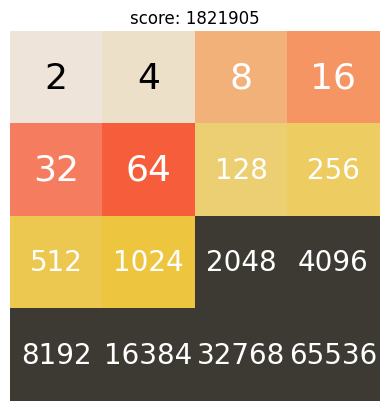

In [5]:
game = Game()

game.state.grid = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16]])
game.state.score = game.state.estimate_score()
game.plot_on_axis(plt.gca())
plt.show()

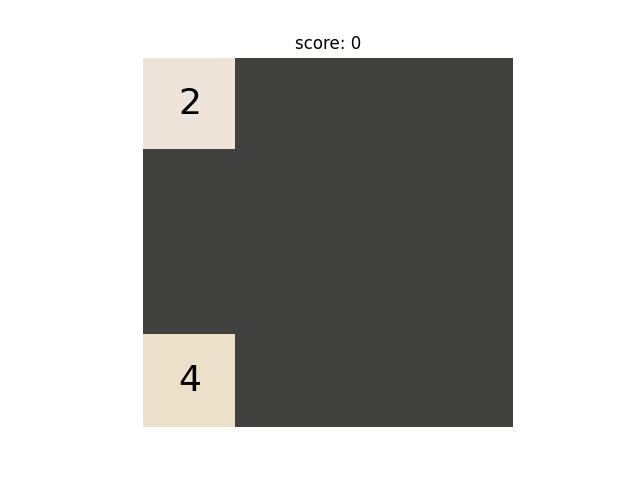

In [ ]:
%matplotlib widget

game = Game(shape=(4,4))
#game.state.warm_start(tiles=[1,2,3,4,5,6,7,8,9,10,11,12], p=[20,10,5,5,4,3,1,1,1,1,1,1], n=3)
plot_arrows = False
stdout = sys.stdout

def on_press(e):
    global plot_arrows, stdout
    if not game.alive:
        return
    match e.key:
        case "left":
            r = game.next(Action.LEFT)
        case "right":
            r = game.next(Action.RIGHT)
        case "up":
            r = game.next(Action.UP)
        case "down":
            r = game.next(Action.DOWN)
        case "r":
            plot_arrows = not plot_arrows
        case "z":
            game.undo()
        case _:
            r = False
    game.plot_on_axis(ax, plot_arrows=plot_arrows)
    #ax.set_title(ax.get_title() + f"\nEstimated score: {game.state.estimate_score()}")
    fig.canvas.draw()

fig, ax = plt.subplots()
fig.canvas.mpl_connect('key_press_event', on_press)
game.plot_on_axis(ax)
plt.show()

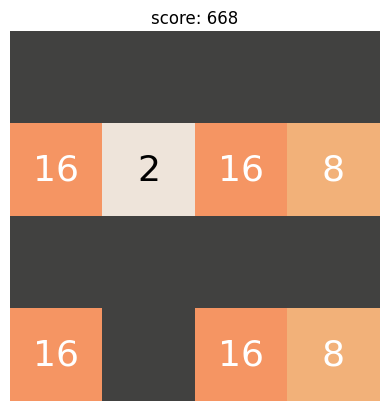

In [ ]:
%matplotlib inline
def plot_on_axis(self, ax: Axes, n: int = -1, clear: bool = True, plot_arrows: bool = False, value_str: str|None = None) -> AxesImage:
    if clear:
        ax.clear()
        [p.remove() for p in reversed(ax.patches)]
    grid = self.history[n].grid
    grid_decoded = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[4,-3,4,-1],])
    score = self.history[n].score
    tile_history = self.history[n].tile_history
    img = ax.imshow(grid, cmap=Game.mpl_cmap, norm=Game.mpl_norm)
    ax.set_axis_off()
    s = ""
    if n != -1:
        s = (f"score {score} (step {n+1 if n >= 0 else len(self.history) + n + 1}/{len(self.history)})")
    elif self.history[n].alive:
        s = (f"score: {score}")
    else:
        s = (f"Game over (score: {score})")
    if value_str is not None:
        s += f"\n{value_str}"
    ax.set_title(s)

    for y in range(grid.shape[0]):
        for x in range(grid.shape[1]):
            if grid[y,x] != 0:
                c = "white" if grid[y,x] >= 3 else "black"
                fsize = 26 if grid[y,x] <= 6 else 20
                plt.text(x, y, grid_decoded[y,x], ha="center", va="center", color=c, fontsize=fsize)

            if plot_arrows:
                th = tile_history[y,x]
                if th == State.TILE_SPAWNED_CONST:
                    ax.add_patch(Rectangle((x-0.5, y-0.5), width=1, height=1, color="red", fill=False))
                elif th < 0:
                    y0, x0 = (-th-1) // grid.shape[1], (-th-1) % grid.shape[1]
                    ax.add_patch(Arrow(x0, y0, (x-x0), (y-y0), color="red", width=0.5, alpha=0.3))
                elif th > 0:
                    y0, x0 = (th-1) // grid.shape[1], (th-1) % grid.shape[1]
                    ax.add_patch(Arrow(x0, y0, (x-x0), (y-y0), color="blue", width=0.5, alpha=0.3))

plot_on_axis(game, plt.gca())
plt.show()

In [ ]:
object.__setattr__(game.state, "grid_decoded", np.array([[0,0,0,0], [1,2,3,4], [2,3,4,5], [4,0,4,3]]) )

AttributeError: property 'grid_decoded' of 'State' object has no setter

In [ ]:
game.state.grid_decoded = 

AttributeError: property 'grid_decoded' of 'State' object has no setter

In [ ]:
game.state.grid[1,2] = 0

In [ ]:
game.state.tile_history[1,2] = 0

In [6]:
game.state.grid = np.array([[0,0,0,0], [1,2,3,4], [0,0,0,0], [2,3,4,5]]) 

### 2 n-Tuple network

In [9]:
from matplotlib.patches import Circle


def draw_dumbbell(ax, p1, p2, radius=0.1, line_color='gray', point_color='blue'):
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color=line_color, linewidth=10)
    for (x, y) in [p1, p2]:
        circle = Circle((x, y), radius, color=point_color, zorder=3)
        ax.add_patch(circle)

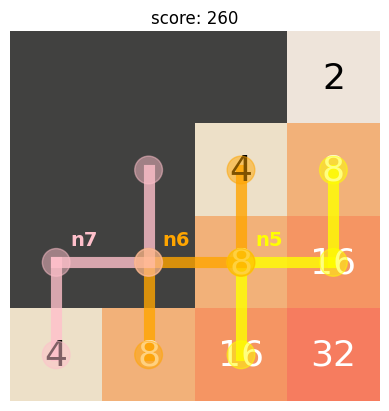

In [ ]:
def plot_ntuple(ax, points: list[tuple[float, float]], color: str, name: str, text_pos: tuple[float, float]):
    for i, (p1, p2) in enumerate(zip(points[:-1], points[1:])):
        ax.plot([p1[1], p2[1]], [p1[0], p2[0]], color=color, linewidth=8, alpha=0.8)
    for (y, x) in points:
        circle = Circle((x, y), 0.15, color=color, alpha=0.5, zorder=10)
        ax.add_patch(circle)
    ax.annotate(name, text_pos, color=color, va="center", ha="center", fontsize=14, weight='bold')
ax = plt.gca()
game.plot_on_axis(ax)
# plot_ntuple(ax, [(3,0), (3,1), (3,2), (3,3)], color="blue", name="n1", text_pos=(1.5, 3.2))
# plot_ntuple(ax, [(2,3), (2,2), (2,1), (2,0)], color="black", name="n2", text_pos=(1.5, 1.8))
# plot_ntuple(ax, [(2.2,0.8), (2.2,0.2), (2.8,0.2), (2.8,0.8)], color="red", name="n3", text_pos=(-0.05, 2.6))
# plot_ntuple(ax, [(2.2,1.8), (2.2,1.2), (2.8,1.2), (2.8,1.8)], color="green", name="n4", text_pos=(0.95, 2.6))
plot_ntuple(ax, [(1,3), (2,3), (2,2), (3,2)], color="yellow", name="n5", text_pos=(2.3, 1.75))
plot_ntuple(ax, [(1,2), (2,2), (2,1), (3,1)], color="orange", name="n6", text_pos=(1.3, 1.75))
plot_ntuple(ax, [(1,1), (2,1), (2,0), (3,0)], color="pink", name="n7", text_pos=(0.3, 1.75))
plt.show()

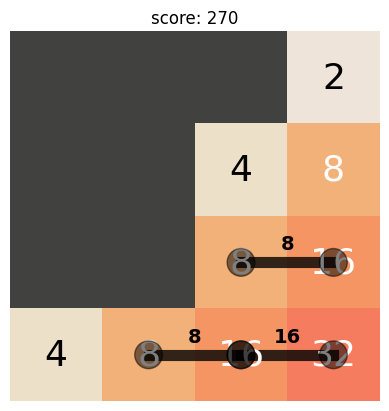

In [15]:
game.state.grid = np.array([[0,0,0,1], [0,0,2,3], [0,0,3,4], [2,3,4,5]])
game.state.score = game.state.estimate_score()
def plot_ntuple(ax, points: list[tuple[float, float]], color: str, name: str, text_pos: tuple[float, float]):
    for i, (p1, p2) in enumerate(zip(points[:-1], points[1:])):
        ax.plot([p1[1], p2[1]], [p1[0], p2[0]], color=color, linewidth=8, alpha=0.8)
    for (y, x) in points:
        circle = Circle((x, y), 0.15, color=color, alpha=0.5, zorder=10)
        ax.add_patch(circle)
    ax.annotate(name, text_pos, color=color, va="center", ha="center", fontsize=14, weight='bold')
ax = plt.gca()
game.plot_on_axis(ax)
plot_ntuple(ax, [(3,1), (3,2)], color="black", name="8", text_pos=(1.5, 2.8))
plot_ntuple(ax, [(3,2), (3,3)], color="black", name="16", text_pos=(2.5, 2.8))
plot_ntuple(ax, [(2,2), (2,3)], color="black", name="8", text_pos=(2.5, 1.8))
plt.show()

#